# Setup

In [1]:
import os
import sys

sys.path.append(os.getcwd().split('notebooks')[0])

from src.utilities.utils import *
# from src.utilities.helper_functions import *

Device: cpu


In [2]:
import time

import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
import torch

from torch import nn, save, load
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# Some Functions

In [4]:
def save_tensor(tensor, save_path):
    torch.save(tensor.clone().detach(), save_path)
    print(f"\nSuccessfully saved tensor to \n{save_path}\n")

In [5]:
def convert_categorical(data):

    if (type(data) == type(np.array(0))):
        
        if (len(data.shape) == 1): df = np.array([data])

        new_one = list()
        for y in df:
        
            vals = list(set(list(y)))
            
            val_dict = dict()
            for v in range(len(vals)): val_dict[vals[v]] = v
            
            new_one += [[val_dict[i] for i in y]]
    
            del vals, val_dict

        new_one = np.array(new_one)
            
        return new_one
        
    else:
        df = data
        num_c = len(list(df.columns))
        
        for c in range(num_c):
            
            if (type(data.iloc[:, c][0]) != str): continue

            vals = list(set(df.iloc[:, c]))

            t_d = dict()

            for v in range(len(vals)):
                val = vals[v]
                t_d[val] = v

            df.iloc[:, c] = df.iloc[:, c].map(lambda x: t_d[x])
            
        return df

In [6]:
def train_block(clf, opt, loss_fn, X_train, Y_train, num_epochs = 10, batch_size = 128):

    train = list()
    for i in range(len(X_train)):
        train.append((X_train[i], Y_train[i]))

    trainloader = DataLoader(train, batch_size)

    for epoch in range(1, num_epochs+1):

        for batch in trainloader:

            x,y = batch 
            Yhat = clf(x)

            loss = loss_fn(Yhat, y)

            #backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()    
    
    return clf

In [7]:
class NN_clf(nn.Module):
    def __init__(self, input_dim, hidden_dim = 100, num_fc = 2, act = 'relu', dropout_p = 0.1, num_classes = 2):
        super(NN_clf, self).__init__()
        
        self.num_fc = num_fc

        self.in_ = nn.Linear(input_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(p=dropout_p)
        
        if (act == 'relu'):
            self.act = nn.ReLU()
            
        elif (act == 'tanh'):
            self.act = nn.Tanh()
            
        elif (act == 'sigmoid'):
            self.act = nn.Sigmoid()
        
        self.out_ = nn.Linear(hidden_dim, num_classes)        
        
    def forward(self, x):

        x = self.in_(x)
        
        for i in range(self.num_fc):

            x = self.fc(x)
            x = self.act(x)
            x = self.dropout(x)
            

        x = self.out_(x)

        
        return x

In [8]:
def return_NN_eval(x, 
                    y, 
                    scaler_type = None,
                    PCA_components = None,
                    input_dim = None, 
                    hidden_dim = 100, 
                    num_fc = 2, 
                    act = 'relu', 
                    dropout_p = 0.1, 
                    num_classes = None, 
                    n_splits = 5, 
                    lr=1e-3, 
                    wd=1e-4, 
                    num_epochs=10, 
                    batch_size=128, 
                    smote_train=False):

    if num_classes is None:
        class_num = len(set([int(b) for b in y.cpu()]))
    else:
        class_num = num_classes
        
    if input_dim is None:
        input_d = x.shape[1]
    else:
        input_d = input_dim

    kf = KFold(n_splits=n_splits, shuffle = True, random_state = 18)
    kf.get_n_splits(x)
    
    loss_fn = nn.CrossEntropyLoss()        

    overall_metric = 0
    for i, (train_index, test_index) in enumerate(kf.split(x)):

        model = NN_clf(input_dim = input_d,
                       hidden_dim = hidden_dim,
                       num_fc = num_fc,
                       act = act,
                       dropout_p = dropout_p,
                       num_classes = class_num).to(device)
        
        # opt = Adam(model.parameters(), lr=lr, weight_decay=wd)
        opt = SGD(model.parameters(), lr=lr, weight_decay=wd)

        X_train = x[train_index]
        X_test = x[test_index]

        Y_train = y[train_index]
        Y_test = y[test_index]

        if (smote_train):
            smote = SMOTE(random_state=18)
            X_train, Y_train = smote.fit_resample(X_train.cpu(), Y_train.cpu())
            
            X_train, Y_train = torch.tensor(X_train, dtype = torch.float32).to(device), torch.tensor(Y_train, dtype = torch.long).to(device)
            
            
        if (scaler_type is not None):
            
            if (scaler_type == 'standard'):
                
                scaler = StandardScaler()
                scaler = scaler.fit(X_train.cpu())   
                
                scale = lambda to_scale: scaler.transform(to_scale.cpu()).to(device) 
                
            elif (scaler_type == 'minmax'):
                scale = lambda to_scale: ((to_scale.cpu() - to_scale.cpu().min())/(to_scale.cpu().max() - to_scale.cpu().min())).to(device)
                
                
            # do nothing
            else: scale = lambda to_scale: to_scale
                
        # do nothing
        else: scale = lambda to_scale: to_scale
            
        
        if (PCA_components is not None):
                
            pca = PCA(n_components=PCA_components)
            pca.fit(X_train.cpu())
            
            do_pca = lambda to_pca: pca.transform(to_pca.cpu()).to(device)
            
        # do nothing
        else: do_pca = lambda to_pca: to_pca    
        
        
        X_train = scale(X_train)
        X_train = do_pca(X_train)
        
        model = train_block(model,
                            opt = opt,
                            loss_fn = loss_fn, 
                            X_train = X_train,
                            Y_train = Y_train, 
                            num_epochs = num_epochs,
                            batch_size = batch_size)
        
        
        X_test = scale(X_test)
        X_test = do_pca(X_test)
        
        preds = model(X_test).cpu().detach().numpy()
        
        pred_labels = torch.tensor([x.argmax() for x in preds], dtype = torch.long)
        
        # _______ insert evaluation metric ___________________________________
        
        if (len(set(y)) == 2): average = 'binary'
        else: average = 'weighted'
            
        metric_value = f1_score(Y_test.cpu(), pred_labels.cpu(), average = average)
        
        # ____________________________________________________________________
        
        overall_metric += metric_value
        
        del model
            
    return (overall_metric/n_splits)

In [9]:
# def convert_categorical(df):

#     num_c = len(list(df.columns))
    
#     for c in range(num_c):
        
#         if (type(data.iloc[:, c][0]) != str): continue

#         vals = list(set(df.iloc[:, c]))

#         t_d = dict()

#         for v in range(len(vals)):
#             val = vals[v]
#             t_d[val] = v

#         df.iloc[:, c] = df.iloc[:, c].map(lambda x: t_d[x])
        
#     return df

# Get Data

### Get Classification Dataset

In [10]:
data = pd.read_csv(f'{data_folder}dermatology_database.csv')

X = np.array(data.iloc[:, :-2])
Y = np.array(data.iloc[:, -1])-1

del data

In [11]:
# data = np.array(pd.read_csv(f"{data_folder}alzheimers_disease_data.csv"))

# X = data[:, :-1]
# Y = data[:, -1]

# del data

In [12]:
# data = pd.read_csv(f"{data_folder}glass.data", names = [f"Feature_{i}" for i in range(1, 10+1)] + ['Target'])

# X = np.array(data.iloc[:, 1:-1])
# Y = convert_categorical(np.array(data.iloc[:, -1], dtype = np.int8)).squeeze()

# del data

In [13]:
# data = np.load(f"{data_folder}MiniBoone_Particle_ID.npy")

# X = data[:, :-1]
# Y = data[:, -1]

# del data

In [14]:
# data = pd.read_csv(f"{data_folder}spambase.data", 
#                    names = [f"Feature_{i}" for i in range(1, 57)] + ['Target'])

# X = np.array(data.iloc[:, :-1])
# Y = np.array(data.iloc[:, -1])

# del data

In [15]:
# data = np.array(pd.read_csv(f"{data_folder}alzheimers_disease_data.csv"))

# X = data[:, :-1]
# Y = data[:, -1]

# del data

In [16]:
# data = pd.read_csv(f"{data_folder}car.data", names = [f"Feature_{i}" for i in range(1, 7)] + ['Target'])
# data = np.array(convert_categorical(data), dtype = np.int8)

# X = torch.tensor(data[:, :-1], dtype = torch.float32)
# Y = torch.tensor(data[:, -1], dtype = torch.long)

# del data

### Look at Data

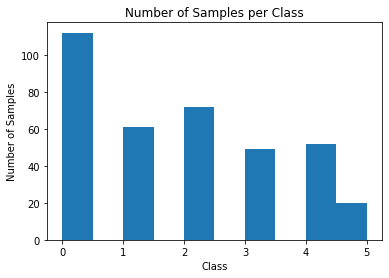

In [17]:
plt.hist([int(y) for y in Y])
plt.title("Number of Samples per Class")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

In [18]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: (366, 33); Y Shape: (366,)


### Get Subset

In [19]:
def get_subset(x, y, portion=1, random_state=18):
    
    if (portion>=1): return x, y
    
    X, tx, Y, ty = train_test_split(x, y, test_size=(1-portion), random_state=random_state)
    del tx, ty
    
    return X, Y

In [20]:
X, Y = get_subset(X, Y, 
                #   portion=0.02, 
                  random_state=18)

X, Y = torch.tensor(X, dtype = torch.float32).to(device), torch.tensor(Y, dtype = torch.long).to(device)

In [21]:
print(f"X Shape: {X.shape}; Y Shape: {Y.shape}")

X Shape: torch.Size([366, 33]); Y Shape: torch.Size([366])


# Test Model

In [22]:
run_test = False
# run_test = True

print(f"X Shape: {tuple(X.shape)}.\n")

num_classes = len(set([int(y) for y in Y.cpu()]))
print(f"{num_classes} classes.\n\n")

if (run_test):  

    result = return_NN_eval(input_dim = int(X.shape[1]),
                            hidden_dim = 32,                  # can change hidden_dim
                            num_fc = 2,                        # can change number of layers
                            act = 'relu',                      # can change activation function
                            dropout_p = 0,                   # can change dropout probability
                            num_classes = num_classes,
                            x = X.to(torch.float32), 
                            y = Y.to(torch.long), 
                            scaler_type='standard',
                            PCA_components = None,
                            n_splits = 5, 
                            num_epochs=20,                   # can change num_epochs
                            batch_size=1024,                  # can change batch_size
                            lr=5e-3,
                            wd=5e-3,
                            smote_train=False)               # can change SMOTE

    print(f"Evaluation: {result:.4f}.")       
    
    
    del result
    
    result = return_NN_eval(input_dim = int(X.shape[1]),
                            hidden_dim = 32,                  # can change hidden_dim
                            num_fc = 3,                        # can change number of layers
                            act = 'relu',                      # can change activation function
                            dropout_p = 0,                   # can change dropout probability
                            num_classes = num_classes,
                            x = X.to(torch.float32), 
                            y = Y.to(torch.long), 
                            scaler_type='standard',
                            PCA_components = None,
                            n_splits = 5, 
                            num_epochs=20,                   # can change num_epochs
                            batch_size=2048,                  # can change batch_size
                            lr=5e-3,
                            wd=5e-3,
                            smote_train=False)               # can change SMOTE

    print(f"Evaluation: {result:.4f}.")       


X Shape: (366, 33).

6 classes.




In [23]:
# generate error !

# Generate Tensor

In [24]:
def get_size(l, get_str = False):
    total_cells = 1
    if (get_str): s = str()
    for i in range(len(l)): 
        total_cells*=len(l[i])
        
        if ((len(l[i]) != 1) and get_str): 
            
            s += f"{len(l[i])}"
            if (i < (len(l) - 1)): s += "x"
                      
    if (get_str): return total_cells, s
    return total_cells


dim6=[None, 'minmax', 'standard']
dim5=['relu']
dim4=[2, 3, 5, 10, 15, 25]
dim3 = [128, 1024, 2048]
dim2=[1, 2, 3, 5, 10, 15]
dim1=[32, 128, 256, 512]

list_=[dim6,dim5,dim4,dim3,dim2,dim1]
total_cells, s = get_size(list_, get_str = True)
print(f"({s}) tensor output.\n")

print(f"{total_cells} total combinations.")
print(f"X Shape: {tuple(X.shape)}, Y Shape: {tuple(Y.shape)}.")
del list_, s

(3x6x3x6x4) tensor output.

1296 total combinations.
X Shape: (366, 33), Y Shape: (366,).


In [25]:
start_time = time.time()
print("Beginning Tensor Generation...\n")

i = 0
num_classes = len(set([int(y) for y in Y]))
times = list()

tensor_6 = list()
for scaler_type in dim6:
    tensor_5 = list()
    for act in dim5:
        tensor_4 = list()
        for num_epochs in dim4:
            tensor_3 = list()
            for batch_size in dim3:
                tensor_2 = list()
                for num_fc in dim2:
                    tensor_1 = list()
                    for hidden_dim in dim1:
                        it_start = time.time()
                        result = return_NN_eval(x = X, 
                                                y = Y, 
                                                PCA_components=None,
                                                scaler_type=scaler_type,
                                                input_dim = int(X.shape[1]), 
                                                hidden_dim = hidden_dim, 
                                                num_fc = num_fc, 
                                                act = act, 
                                                dropout_p = 0, 
                                                num_classes = num_classes, 
                                                n_splits = 5, 
                                                lr=5e-3, 
                                                wd=1e-3, 
                                                num_epochs=num_epochs, 
                                                batch_size=batch_size, 
                                                smote_train=False)

                        i+=1
                        
                        times += [time.time() - it_start]
                        
                        if (i%10==0 or i==total_cells): 
                            print(f"{i}/{total_cells} combinations done. Average Iteration Time: {(np.array(times).mean()):.2f}. {(time.time() - start_time):.4f} time since start.")

                        tensor_1+= [result]

                    tensor_2+= [tensor_1]

                tensor_3+= [tensor_2]

            tensor_4+= [tensor_3]
            
        tensor_5 += [tensor_4]
        
    tensor_6 += [tensor_5]

    print(f"\n{len(tensor_6)}/{len(dim6)} 5th order tensors done.\n")

tensor = torch.tensor(tensor_6).squeeze()

print(f"\nTensor done! Tensor Shape {tensor.shape}\n{np.array(times).mean():.2f}  Average Iteration Time ; {(time.time() - start_time):.2f} total runtime")

Beginning Tensor Generation...



10/1296 combinations done. Average Iteration Time: 0.13. 1.2998 time since start.
20/1296 combinations done. Average Iteration Time: 0.15. 2.9583 time since start.
30/1296 combinations done. Average Iteration Time: 0.14. 4.1533 time since start.
40/1296 combinations done. Average Iteration Time: 0.12. 4.8081 time since start.
50/1296 combinations done. Average Iteration Time: 0.11. 5.7226 time since start.
60/1296 combinations done. Average Iteration Time: 0.11. 6.3190 time since start.
70/1296 combinations done. Average Iteration Time: 0.10. 7.1526 time since start.
80/1296 combinations done. Average Iteration Time: 0.11. 8.4855 time since start.
90/1296 combinations done. Average Iteration Time: 0.12. 10.4024 time since start.
100/1296 combinations done. Average Iteration Time: 0.12. 12.3372 time since start.
110/1296 combinations done. Average Iteration Time: 0.12. 13.1147 time since start.
120/1296 combinations done. Average Iteration Time: 0.12. 14.4629 time since start.
130/1296 

In [26]:
tensor = torch.tensor(tensor_6).squeeze()

Generated Tensor shape: (3, 6, 3, 6, 4)


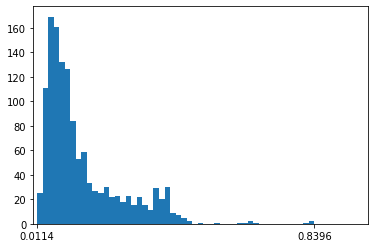

In [27]:
print(f"Generated Tensor shape: {tuple(tensor.shape)}")

plt.hist(list([float(x) for x in tensor.flatten()]), bins = 50)
plt.xlim(0, 1)
plt.xticks([tensor.min(), tensor.max()])

plt.show()

In [30]:
if (False):
    save_tensor(tensor,
                save_path = f"{work_dir}training_tensors/deep_learning/FCNN_Dermatology_903.pt")


Successfully saved tensor to 
/home/spaka002/NSF_REU_2024/training_tensors/deep_learning/FCNN_Dermatology_903.pt

